In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [1]:
import numpy as np
import os
import zipfile
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
print("Tensorflow version: ", tf.__version__)

# tf.compat.v1.disable_eager_execution()

Tensorflow version:  2.11.0


In [2]:
# Unzip data
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [4]:
SEED = 2405
tf.random.set_seed(SEED)

In [5]:
IMAGE_DIR = './train'
TEST_DIR = './test1'
# Create dataframe
filenames = os.listdir(IMAGE_DIR)
labels = [x.split(".")[0] for x in filenames]
df = pd.DataFrame({"filename": filenames, "label": labels})
df.head()

filename label
0  cat.11974.jpg   cat
1   cat.4019.jpg   cat
2   cat.8232.jpg   cat
3   cat.2451.jpg   cat
4   cat.1484.jpg   cat

In [6]:
test_filenames = os.listdir(TEST_DIR)
# test_labels = [x.split(".")[0] for x in test_filenames]
test_df = pd.DataFrame({"filename": test_filenames})
test_df.head()

filename
0  11925.jpg
1   6204.jpg
2  12488.jpg
3   9505.jpg
4   3157.jpg

In [7]:
df.label.value_counts()

cat    12500
dog    12500
Name: label, dtype: int64

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(train_df.label.value_counts())
print(val_df.label.value_counts())

cat    10005
dog     9995
Name: label, dtype: int64
dog    2505
cat    2495
Name: label, dtype: int64


In [9]:
train_df.head()

filename label
0  cat.12238.jpg   cat
1   cat.2900.jpg   cat
2   dog.9376.jpg   dog
3   cat.7677.jpg   cat
4  cat.10828.jpg   cat

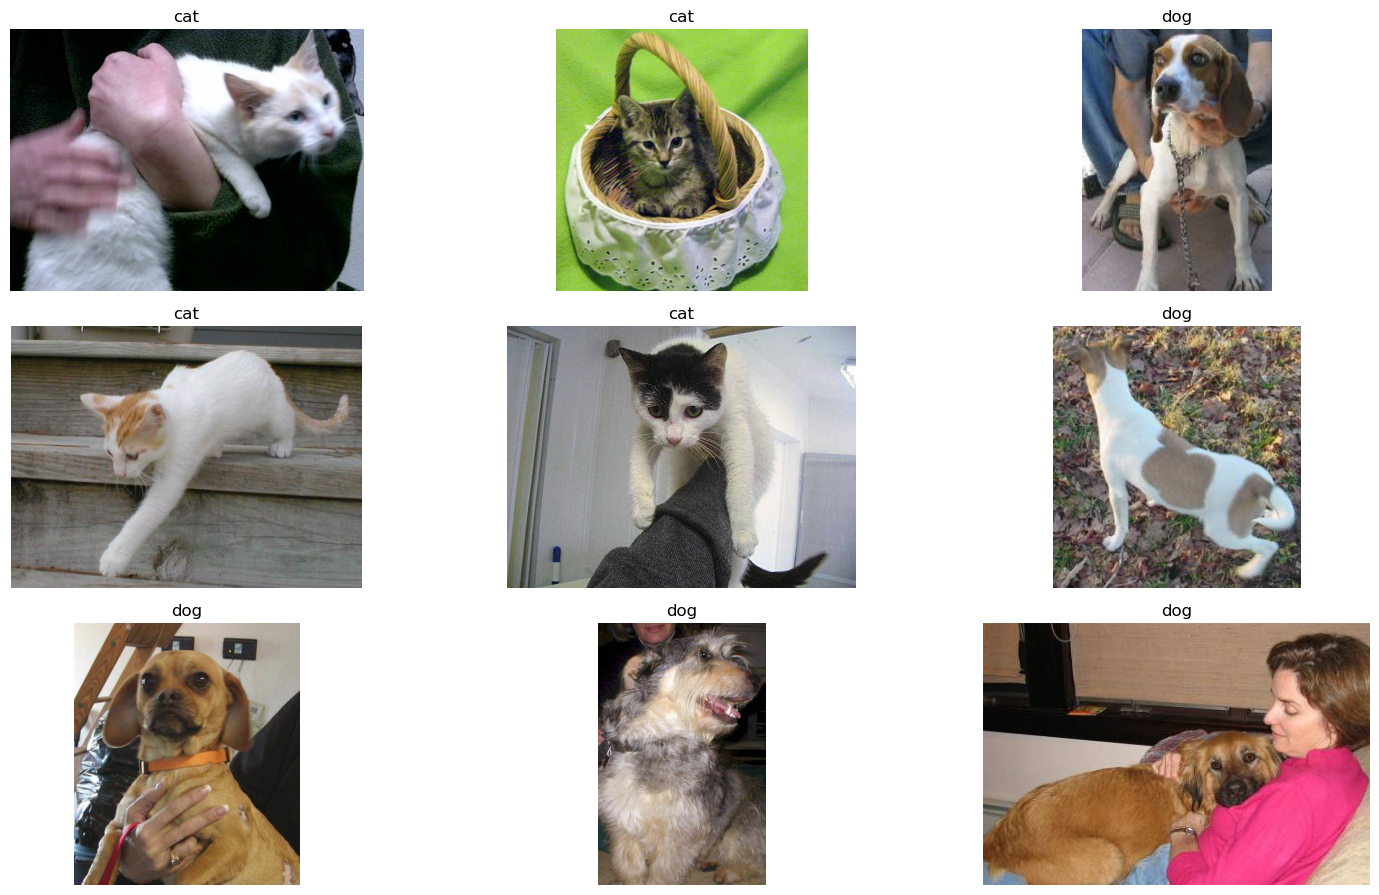

In [10]:
plt.figure(figsize=(15,15))
for i in range(0, 9):
    plt.subplot(5,3,i+1)
    filename, label = train_df.iloc[i]
    # read image from filename
    img = cv2.imread(os.path.join(IMAGE_DIR, filename))
    # convert image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot image
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.layers[-1].output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

In [22]:
adam = optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss = "categorical_crossentropy", metrics=["accuracy"])

NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
earlystoper = EarlyStopping(monitor="val_loss", patience=5)
checkpointer = ModelCheckpoint(filepath="../working/resnet50best.hdf5", monitor='val_loss', save_best_only=True, mode='auto')
callbacks = [earlystoper, checkpointer]

In [ ]:
batch_size = 100
W, H = 100, 100
epochs = 10

In [ ]:
# Train generator
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_datagen.flow_from_dataframe(train_df, IMAGE_DIR, x_col="filename", y_col="label",
                                                    target_size=(W,H), class_mode="categorical",
                                                   batch_size=batch_size, shuffle=True, seed=SEED)
# Validation generator
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_generator = val_datagen.flow_from_dataframe(val_df, IMAGE_DIR, x_col="filename", y_col="label",
                                               target_size=(W,H), class_mode="categorical",
                                                batch_size=batch_size)

In [16]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=20,
    steps_per_epoch=20,
    callbacks=callbacks
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
20/20 [==============================] - 27s 898ms/step - loss: 1.8878 - accuracy: 0.4440 - val_loss: 1.5030 - val_accuracy: 0.4945
Epoch 2/10
20/20 [==============================] - 17s 863ms/step - loss: 1.1457 - accuracy: 0.5800 - val_loss: 0.9921 - val_accuracy: 0.6330
Epoch 3/10
20/20 [==============================] - 16s 837ms/step - loss: 0.7740 - accuracy: 0.6900 - val_loss: 0.7440 - val_accuracy: 0.7140
Epoch 4/10
20/20 [==============================] - 16s 827ms/step - loss: 0.6591 - accuracy: 0.7400 - val_loss: 0.5697 - val_accuracy: 0.7645
Epoch 5/10
20/20 [==============================] - 16s 833ms/step - loss: 0.4985 - accuracy: 0.7960 - val_loss: 0.4739 - val_accuracy: 0.7960
Epoch 6/10
20/20 [==============================] - 16s 845ms/step - loss: 0.4836 - accuracy: 0.8090 - val_loss: 0.4573 - val_accuracy: 0.8135
Epoch 7/10
20/20 [==============================] - 16s 842ms/step - loss: 0.4138 - accuracy: 0.8415 - val_loss: 0.3973 - val_accuracy: 0.8305

In [ ]:
model.load_weights("../working/resnet50best.hdf5")

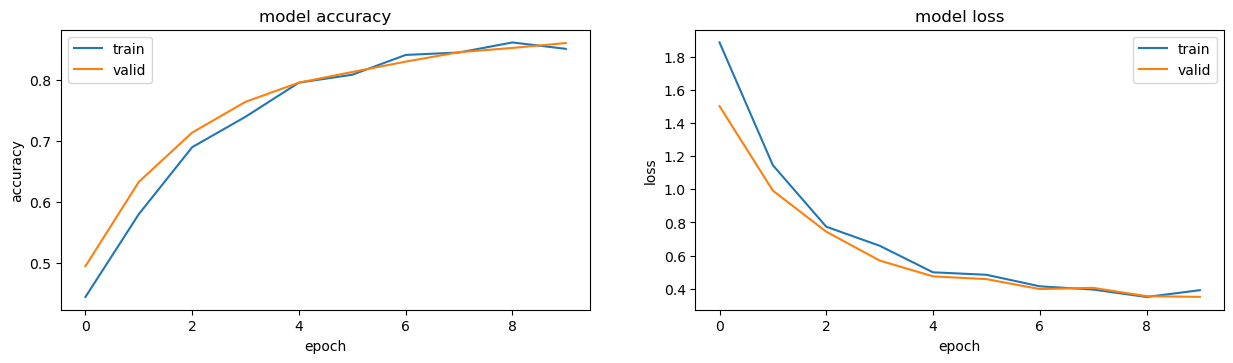

In [18]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [20]:
# import tensorflow._api.v2.compat.v1 as tf

# tf.disable_v2_behavior()

In [28]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
print(K.image_data_format())

channels_last


In [29]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for layer in model.layers:
  print(layer.name)

input_1
conv1_pad
conv1_conv
pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_pad
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_out
conv2_block2_preact_bn
conv2_block2_preact_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_pad
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_out
conv2_block3_preact_bn
conv2_block3_preact_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_pad
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
max_pooling2d_3
conv2_block3_3_conv
conv2_block3_out
conv3_block1_preact_bn
conv3_block1_preact_relu
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_pad
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_out
conv3_block2_p

In [77]:
# filter_index can be any integer from 0 to 511, as there are 512 filters in that layer
loss = K.mean(layer_dict['conv4_block3_1_conv'].output[:, :, :, np.random.randint(0,20):512:np.random.randint(50,100)])

(1, 200, 200, 3) 0 254
(1, 200, 200, 3) -1.0 0.99215686


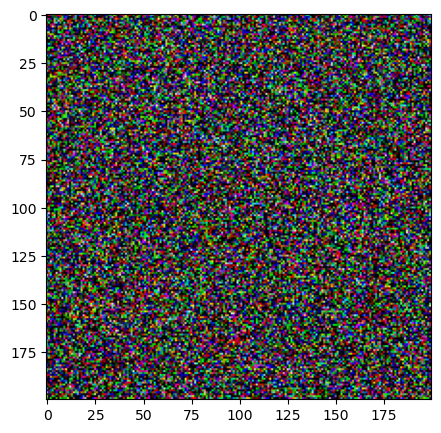

In [78]:
import numpy as np

img_width = 200
img_height  = 200

# we start from a gray image with some noise
# input_img_data = np.random.random((1, img_width, img_height, 3)) #* 20 + 128.

input_img_data = np.random.randint(0,255,(1, img_width, img_height, 3))
print(input_img_data.shape, np.min(input_img_data), np.max(input_img_data))
input_img_data = preprocess_input(input_img_data)
print(input_img_data.shape, np.min(input_img_data), np.max(input_img_data))

plt.figure(figsize=(5,5))
plt.imshow(input_img_data[0])

In [79]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, model.input)[0]

# normalization trick: we normalize the gradient
grads /= K.std(grads) + 1e-8

# this function returns the loss and grads given the input picture
iterate = K.function([model.input], [loss, grads])

In [80]:
from tqdm import tqdm_notebook as tqdm

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/800 [00:00<?, ?it/s]

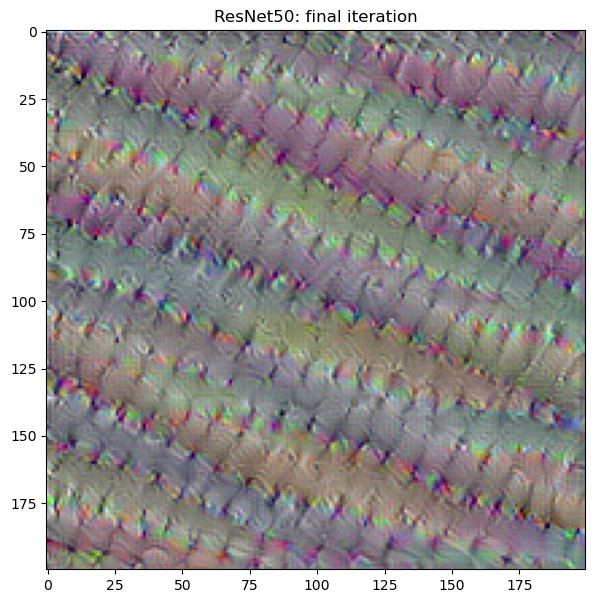

In [81]:
# run gradient ascent for n steps
images = []
loss_list = []

for i in tqdm(range(800)):
    loss_value, grads_value = iterate([input_img_data])
    loss_list.append(loss_value)
    input_img_data += grads_value * 0.01
    if(i%5 == 0):
      #print(i, loss_value, np.mean(grads_value), np.std(grads_value))
      img = input_img_data[0]
      img = deprocess_image(img)
      images.append(img)

img = input_img_data[0]
img = deprocess_image(img)
images.append(img)
plt.figure(figsize=(7,7))
plt.title('ResNet50: final iteration')
plt.imshow(img)

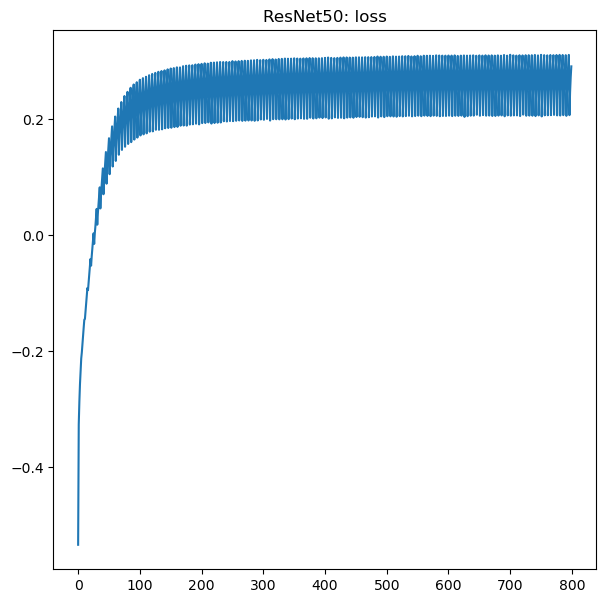

In [66]:
# plot the loss
plt.figure(figsize=(7,7))
plt.title('ResNet50: loss')
plt.plot(loss_list)

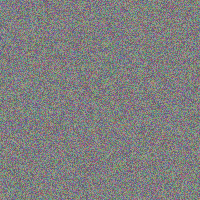

In [40]:
import imageio
from PIL import Image as pil_image
imageio.mimsave('./vgg16.gif', images[:80])
from IPython.display import Image
with open('./vgg16.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

10887.jpg
(374, 500, 3)
(200, 200, 3)


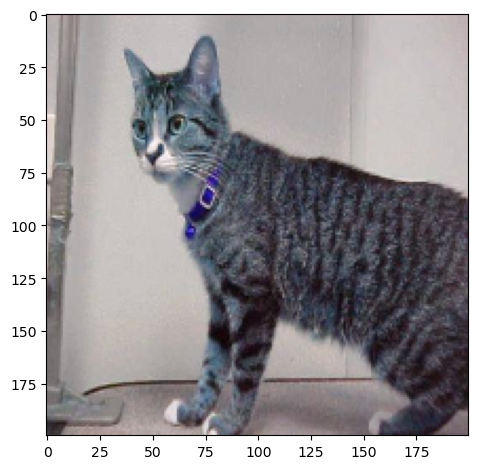

In [135]:
# choose an image
filename = test_df.iloc[72]['filename']
print(filename)
img1 = cv2.imread(os.path.join(TEST_DIR, filename))
print(img1.shape)
img1 = cv2.resize(img1, (200, 200))
print(img1.shape)
plt.imshow(img1)
# plt.title(label)
plt.tight_layout()
plt.show()
img = np.expand_dims(img1, axis=0)
img = preprocess_input(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [136]:
# x = img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
x = img

In [137]:
output_point = model.output[:, 0] #TODO: 0 or 1]

# Select the last conv layer
feature_maps = model.get_layer('conv5_block3_3_conv')

# grads of the output wrt the conv layer
grads = K.gradients(output_point, feature_maps.output)[0]

# grads has the same shape as the selected conv layer
# the weight of each feature map is simple the mean of the grads
mean_grads = K.mean(grads, axis=(0, 1, 2))

# the function
iterate = K.function([model.input], [mean_grads, feature_maps.output[0]])

mean_grads_value, feature_maps_value = iterate([x])

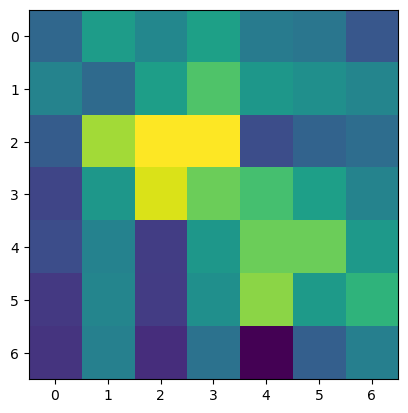

In [138]:
# sample feature mapnumber 200 
feature_map = feature_maps_value[:, :, 200].copy()
feature_map -= feature_map.mean()
feature_map /= feature_map.std()
feature_map *= 64
feature_map += 128
feature_map = np.clip(feature_map, 0, 255).astype('uint8')
plt.imshow(feature_map)

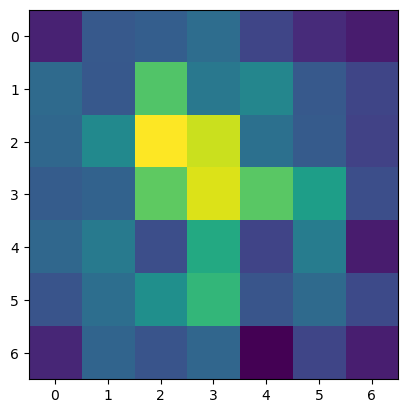

In [139]:
# mean of all feature maps (without weighting)
plt.imshow(np.mean(feature_maps_value, axis=-1))

In [140]:
# weight each feature map by its mean gradinet
for i in range(512):
    feature_maps_value[:, :, i] *= mean_grads_value[i]

# The heatmap the mean of all weighted maps
heatmap = np.mean(feature_maps_value, axis=-1)

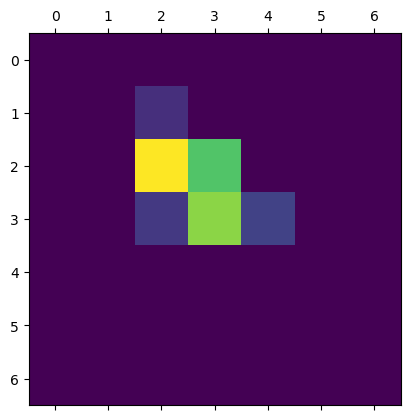

In [141]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

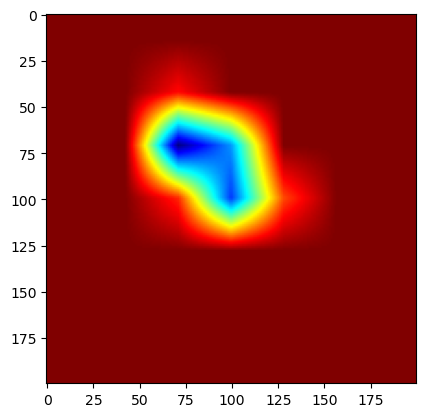

In [142]:
# overlay 
# img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img1.shape[1], img1.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(heatmap)
plt.show()

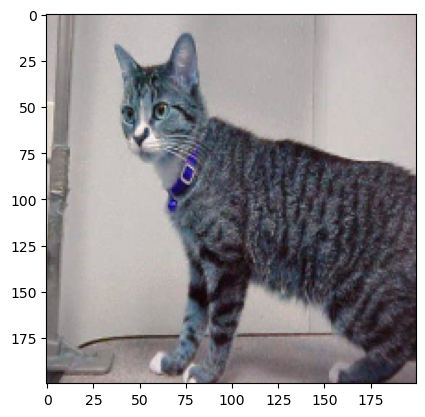

In [143]:
plt.imshow(img1)
plt.show()

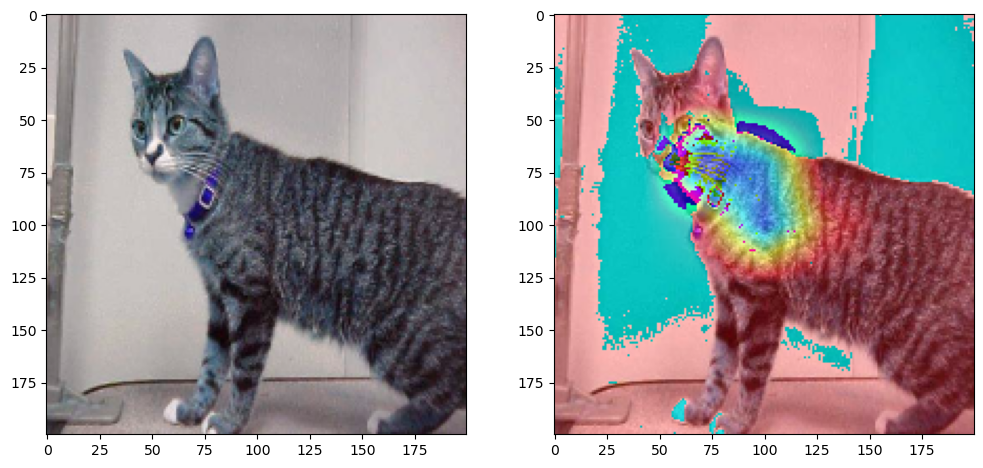

In [144]:
superimposed_img = (heatmap * 0.5).astype('uint8') + img1
# cv2.imshow(superimposed_img)

plt.figure(2, figsize = (12,12)) 
    
plt.subplot(221)  
plt.imshow(img1) 
    
plt.subplot(222)  
plt.imshow(superimposed_img)

plt.show()